In [8]:
# ==== Quick AMP smoke test over several random datasets (no MPI) ====
import numpy as np
from time import perf_counter

import sys
import os

# Add parent folder (one level up from notebook) to Python path
sys.path.append(os.path.abspath(".."))

from amp_experiment import generate_data
from amp import AMP_algo
from state_evolution import generate_latents


def run_many_amp(
    runs=3, alpha = 10, d=300,
    beta_u=1.0, beta_v=2.0, gamma=1.0, delta=0.0,
    plant=0.9, damp=0.2, tol=1e-4, max_iter=200, eps=1e-6, seed0=0
):
    results = []
    n = int(alpha*d)
    for r in range(runs):
        np.random.seed(seed0 + r)
        # --- data ---
        X, y, u_star, v_star = generate_data(n, d, beta_u, beta_v, gamma=gamma, delta=delta)
        w_star = np.stack([u_star, v_star], axis=1)  # (d, 2)

        # Assume you already have X, y, u_star, v_star
        X_pos = X[y == 1]
        y_pos = y[y == 1]

        ## make this simpler, remove y


        # --- run AMP ---
        t0 = perf_counter()
        w, overlap_hist, converged = AMP_algo(
            X_pos, y_pos, K=2,
            beta_u=beta_u, beta_v=beta_v, gamma=gamma, delta=delta,
            max_iter=max_iter, tol=tol, plant=plant, damp=damp,
            w_star=w_star, eps=eps, rank=None  # no MPI
        )
        t1 = perf_counter()

        # final overlap matrix (KxK)
        Q_final = overlap_hist[-1]
        print("Q")
        print(Q_final)

        print(f"[run {r}] converged={converged} | steps={len(overlap_hist)-1} | time={t1-t0:.2f}s")

        results.append({
            "run": r,
            "converged": converged,
            "steps": len(overlap_hist)-1,
            "time_s": t1 - t0,
            "w": w,
            "overlap_hist": overlap_hist,  # shape: T x K x K
        })
    return results

# ---- go! tweak sizes to taste ----
res = run_many_amp(
    runs=5, alpha=70, d=1000,
    beta_u=1.0, beta_v=2.0, gamma=0.0, delta=0.0,
    plant=1.0, damp=0.95, tol=1e-4, max_iter=500, eps=1e-6, seed0=120
)


Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Converged at iter 223
Q
[[ 9.51735125e-01 -4.39394491e-02]
 [-9.84482304e-05  1.41497786e-03]]
[run 0] converged=True | steps=224 | time=190.35s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Converged at iter 346
Q
[[ 0.88429933 -0.01168908]
 [ 0.00807783  0.95198636]]
[run 1] converged=True | steps=347 | time=279.49s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
It

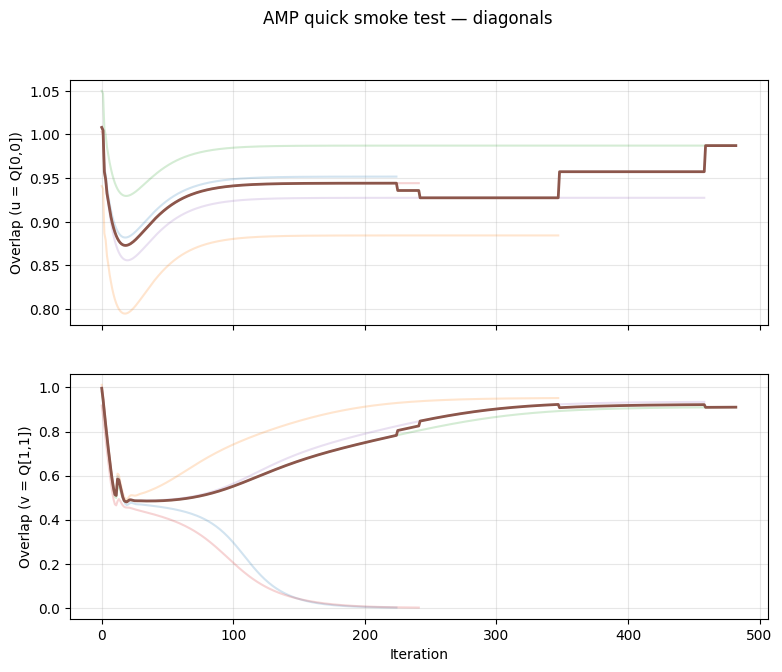

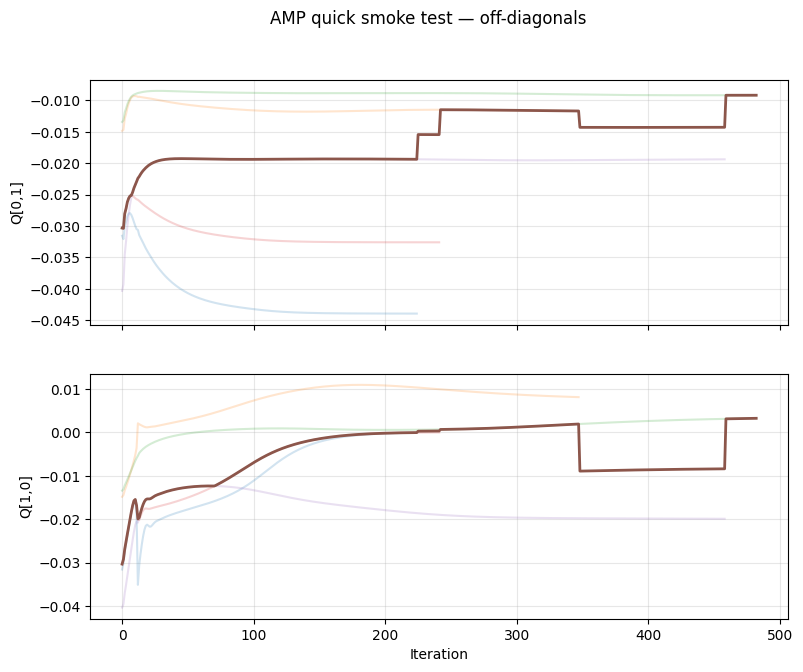

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overlap_histories(res, show_offdiag=True, title_prefix="AMP overlaps vs iterations"):
    # Collect histories; each is (T_i, 2, 2)
    H_list = [r["overlap_hist"] for r in res if isinstance(r.get("overlap_hist"), np.ndarray)]
    if not H_list:
        raise ValueError("No overlap histories in res.")

    T_max = max(H.shape[0] for H in H_list if H.size)
    U = np.full((len(H_list), T_max), np.nan)
    V = np.full((len(H_list), T_max), np.nan)
    UV = np.full((len(H_list), T_max), np.nan)
    VU = np.full((len(H_list), T_max), np.nan)

    k = 0
    for H in H_list:
        if H.ndim != 3 or H.shape[1:] != (2, 2):
            continue
        T = H.shape[0]
        U[k, :T]  = H[:, 0, 0]
        V[k, :T]  = H[:, 1, 1]
        UV[k, :T] = H[:, 0, 1]
        VU[k, :T] = H[:, 1, 0]
        k += 1
    if k == 0:
        raise ValueError("No valid (T,2,2) histories found.")

    U = U[:k]; V = V[:k]; UV = UV[:k]; VU = VU[:k]
    u_med  = np.nanmedian(U,  axis=0)
    v_med  = np.nanmedian(V,  axis=0)
    uv_med = np.nanmedian(UV, axis=0)
    vu_med = np.nanmedian(VU, axis=0)

    # --- Diagonals (u, v)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
    fig.suptitle(f"{title_prefix} — diagonals")

    for i in range(U.shape[0]):
        ax1.plot(U[i], alpha=0.2)
        ax2.plot(V[i], alpha=0.2)

    ax1.plot(u_med, linewidth=2)
    ax2.plot(v_med, linewidth=2)

    ax1.set_ylabel("Overlap (u = Q[0,0])")
    ax2.set_ylabel("Overlap (v = Q[1,1])")
    ax2.set_xlabel("Iteration")
    ax1.grid(True, alpha=0.3); ax2.grid(True, alpha=0.3)
    plt.show()

    # --- Off-diagonals (optional)
    if show_offdiag:
        fig2, (bx1, bx2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
        fig2.suptitle(f"{title_prefix} — off-diagonals")

        for i in range(UV.shape[0]):
            bx1.plot(UV[i], alpha=0.2)
            bx2.plot(VU[i], alpha=0.2)

        bx1.plot(uv_med, linewidth=2)
        bx2.plot(vu_med, linewidth=2)

        bx1.set_ylabel("Q[0,1]")
        bx2.set_ylabel("Q[1,0]")
        bx2.set_xlabel("Iteration")
        bx1.grid(True, alpha=0.3); bx2.grid(True, alpha=0.3)
        plt.show()

# call it:
plot_overlap_histories(res, show_offdiag=True, title_prefix="AMP quick smoke test")


In [1]:
# ==== Quick AMP smoke test over several random datasets (no MPI) ====
import numpy as np
from time import perf_counter

import sys
import os

# Add parent folder (one level up from notebook) to Python path
sys.path.append(os.path.abspath(".."))

from amp_experiment import generate_data
from amp import AMP_algo
from state_evolution import generate_latents


def run_many_amp(
    runs=3, alpha = 10, d=300,
    beta_u=1.0, beta_v=2.0, gamma=1.0, delta=0.0,
    plant=0.9, damp=0.2, tol=1e-4, max_iter=200, eps=1e-6, seed0=0
):
    results = []
    n = int(alpha*d)
    for r in range(runs):
        np.random.seed(seed0 + r)
        # --- data ---
        X, y, u_star, v_star = generate_data(n, d, beta_u, beta_v, gamma=gamma, delta=delta)
        w_star = np.stack([u_star, v_star], axis=1)  # (d, 2)

        # Assume you already have X, y, u_star, v_star
        X_pos = X[y == 1]
        y_pos = y[y == 1]

        ## make this simpler, remove y


        # --- run AMP ---
        t0 = perf_counter()
        w, overlap_hist, converged = AMP_algo(
            X_pos, y_pos, K=2,
            beta_u=beta_u, beta_v=beta_v, gamma=gamma, delta=delta,
            max_iter=max_iter, tol=tol, plant=plant, damp=damp,
            w_star=w_star, eps=eps, rank=None, assume_concentration=True  # no MPI
        )
        t1 = perf_counter()

        # final overlap matrix (KxK)
        Q_final = overlap_hist[-1]
        print("Q")
        print(Q_final)

        print(f"[run {r}] converged={converged} | steps={len(overlap_hist)-1} | time={t1-t0:.2f}s")

        results.append({
            "run": r,
            "converged": converged,
            "steps": len(overlap_hist)-1,
            "time_s": t1 - t0,
            "w": w,
            "overlap_hist": overlap_hist,  # shape: T x K x K
        })
    return results

# ---- go! tweak sizes to taste ----
res = run_many_amp(
    runs=5, alpha=10.0, d=3000,
    beta_u=1.0, beta_v=2.0, gamma=0.0, delta=1.0,
    plant=0.00, damp=0.0, tol=1e-5, max_iter=500, eps=1e-6, seed0=120
)


Iteration 0
Iteration 20
Converged at iter 24
Q
[[-0.65590947  0.026     ]
 [-0.01064337  0.17780311]]
[run 0] converged=True | steps=25 | time=3.95s
Iteration 0
Iteration 20
Converged at iter 23
Q
[[ 0.65164474 -0.01493552]
 [-0.00563527  0.18112217]]
[run 1] converged=True | steps=24 | time=3.94s
Iteration 0
Iteration 20
Converged at iter 22
Q
[[ 0.69625726 -0.02037848]
 [-0.02682356  0.1913833 ]]
[run 2] converged=True | steps=23 | time=3.75s
Iteration 0
Iteration 20
Converged at iter 23
Q
[[-0.63930937  0.01970045]
 [-0.01853754  0.17367578]]
[run 3] converged=True | steps=24 | time=4.11s
Iteration 0
Iteration 20
Converged at iter 22
Q
[[-0.67763624  0.0150719 ]
 [-0.00603989  0.19109507]]
[run 4] converged=True | steps=23 | time=3.87s


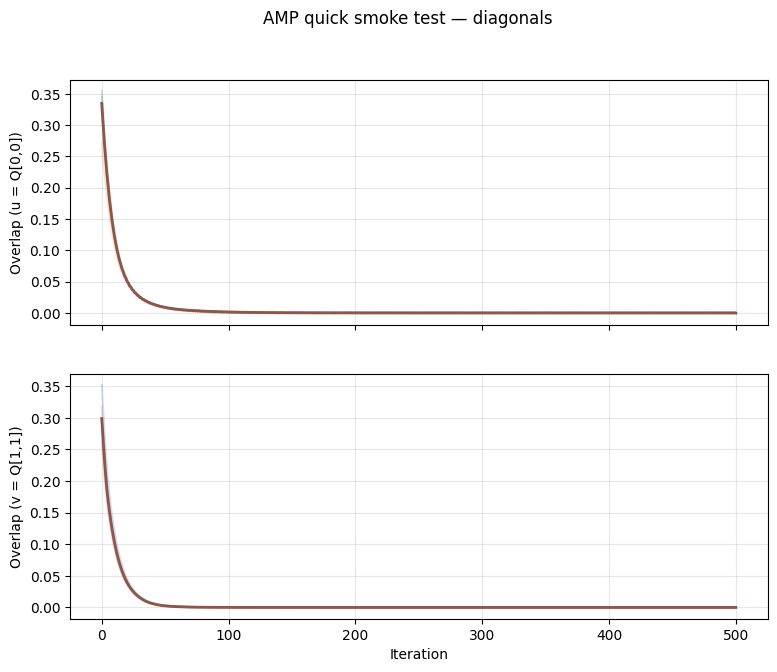

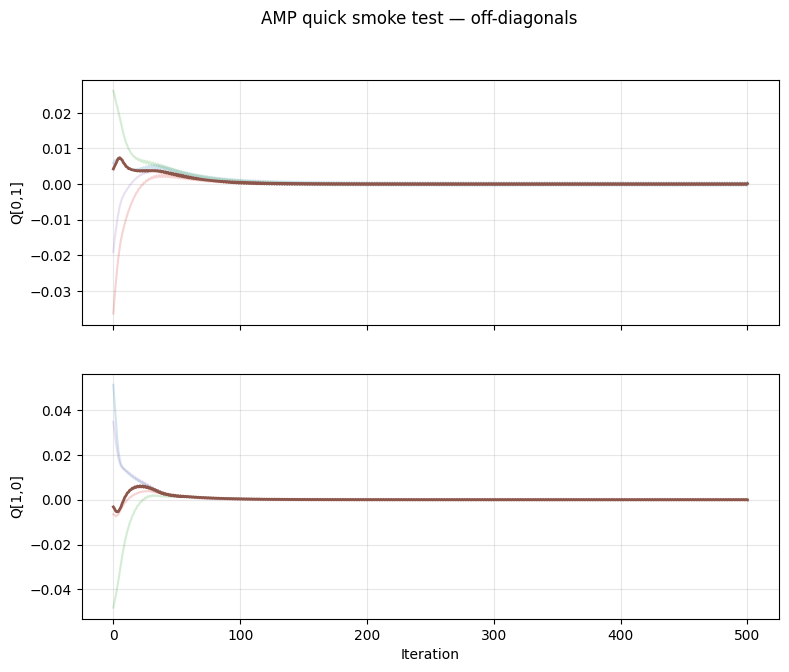

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overlap_histories(res, show_offdiag=True, title_prefix="AMP overlaps vs iterations"):
    # Collect histories; each is (T_i, 2, 2)
    H_list = [r["overlap_hist"] for r in res if isinstance(r.get("overlap_hist"), np.ndarray)]
    if not H_list:
        raise ValueError("No overlap histories in res.")

    T_max = max(H.shape[0] for H in H_list if H.size)
    U = np.full((len(H_list), T_max), np.nan)
    V = np.full((len(H_list), T_max), np.nan)
    UV = np.full((len(H_list), T_max), np.nan)
    VU = np.full((len(H_list), T_max), np.nan)

    k = 0
    for H in H_list:
        if H.ndim != 3 or H.shape[1:] != (2, 2):
            continue
        T = H.shape[0]
        U[k, :T]  = H[:, 0, 0]
        V[k, :T]  = H[:, 1, 1]
        UV[k, :T] = H[:, 0, 1]
        VU[k, :T] = H[:, 1, 0]
        k += 1
    if k == 0:
        raise ValueError("No valid (T,2,2) histories found.")

    U = U[:k]; V = V[:k]; UV = UV[:k]; VU = VU[:k]
    u_med  = np.nanmedian(U,  axis=0)
    v_med  = np.nanmedian(V,  axis=0)
    uv_med = np.nanmedian(UV, axis=0)
    vu_med = np.nanmedian(VU, axis=0)

    # --- Diagonals (u, v)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
    fig.suptitle(f"{title_prefix} — diagonals")

    for i in range(U.shape[0]):
        ax1.plot(U[i], alpha=0.2)
        ax2.plot(V[i], alpha=0.2)

    ax1.plot(u_med, linewidth=2)
    ax2.plot(v_med, linewidth=2)

    ax1.set_ylabel("Overlap (u = Q[0,0])")
    ax2.set_ylabel("Overlap (v = Q[1,1])")
    ax2.set_xlabel("Iteration")
    ax1.grid(True, alpha=0.3); ax2.grid(True, alpha=0.3)
    plt.show()

    # --- Off-diagonals (optional)
    if show_offdiag:
        fig2, (bx1, bx2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
        fig2.suptitle(f"{title_prefix} — off-diagonals")

        for i in range(UV.shape[0]):
            bx1.plot(UV[i], alpha=0.2)
            bx2.plot(VU[i], alpha=0.2)

        bx1.plot(uv_med, linewidth=2)
        bx2.plot(vu_med, linewidth=2)

        bx1.set_ylabel("Q[0,1]")
        bx2.set_ylabel("Q[1,0]")
        bx2.set_xlabel("Iteration")
        bx1.grid(True, alpha=0.3); bx2.grid(True, alpha=0.3)
        plt.show()

# call it:
plot_overlap_histories(res, show_offdiag=True, title_prefix="AMP quick smoke test")

0it [00:00, ?it/s]

Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-2.99484188e-003  7.07148246e-004]
 [ 2.70896147e-153  2.44424111e-151]]
[run 0] converged=False | steps=500 | time=0.61s
Iteration 0
Iteration 20
Converged at iter 36
Q
[[1.17146347e-05 3.88468696e-06]
 [8.36824651e-13 6.33821107e-12]]
[run 1] converged=True | steps=37 | time=0.07s
Iteration 0
Iteration 20
Converged at iter 32
Q
[[ 4.00875739e-06  5.95054843e-07]
 [-8.68918798e-12  9.15255570e-11]]
[run 2] converged=True | steps=33 | time=0.06s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 4.27946521e-05  7.45209707e-07]
 [-7.59860770e-11  1.33020438e-08]]
[run 3] converged=True | steps=26 | time=0.06s
Iteration 0
Iteration 20
Iteration 4

1it [00:02,  2.06s/it]

Iteration 100
Converged at iter 101
Q
[[-4.57410038e-06 -1.95173120e-06]
 [ 7.07904423e-34  1.66793079e-31]]
[run 9] converged=True | steps=102 | time=0.22s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-7.76527297e-004  9.45062575e-005]
 [-1.57155467e-153  2.90127614e-151]]
[run 0] converged=False | steps=500 | time=0.97s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-3.35183662e-003 -2.75435

2it [00:11,  6.54s/it]

Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-5.31789067e-005  4.01906700e-004]
 [ 1.08414672e-152  2.30186796e-151]]
[run 9] converged=False | steps=500 | time=0.93s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-3.63291774e-003  1.40269734e-003]
 [ 1.87310790e-152  2.67269054e-151]]
[run 0] converged=False | steps=500 | time=1.34s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iter

3it [00:25,  9.67s/it]

Iteration 460
Iteration 480
Q
[[-9.02249278e-003 -1.69791114e-003]
 [-2.17623750e-152  2.95484343e-151]]
[run 9] converged=False | steps=500 | time=1.24s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-1.26566678e-003 -4.21266133e-003]
 [-1.35417569e-152  2.59099377e-151]]
[run 0] converged=False | steps=500 | time=2.87s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-3.85918543e-003  1.15122171

4it [00:54, 17.62s/it]

Q
[[-3.60985090e-003 -2.19835719e-003]
 [-1.55911605e-152  2.90427085e-151]]
[run 9] converged=False | steps=500 | time=2.85s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-1.91699545e-003  5.98701844e-003]
 [ 4.43262825e-154  2.19649907e-151]]
[run 0] converged=False | steps=500 | time=3.58s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-2.70026981e-004 -1.42728145e-003]
 [-1.53665167e-152  2

5it [01:29, 23.89s/it]

Q
[[-1.11643781e-003  1.24141700e-003]
 [-7.08358101e-155  2.50651060e-151]]
[run 9] converged=False | steps=500 | time=3.47s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-4.60408010e-003 -5.50668238e-003]
 [-3.63637254e-154  2.69221146e-151]]
[run 0] converged=False | steps=500 | time=4.59s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-3.05473496e-003  6.83972438e-004]
 [-6.82892444e-153  2

6it [02:21, 33.38s/it]

Q
[[3.49967902e-002 2.48964738e-002]
 [2.19058922e-152 2.20150223e-151]]
[run 9] converged=False | steps=500 | time=4.15s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-2.33550460e-003 -3.85832058e-003]
 [ 3.37662633e-152  2.71304505e-151]]
[run 0] converged=False | steps=500 | time=4.99s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Q
[[-2.08288858e-003 -1.33410862e-003]
 [ 4.17378023e-153  2.887

7it [03:11, 38.65s/it]

Iteration 480
Q
[[2.28640443e-003 4.58190818e-004]
 [2.15701389e-152 2.57921194e-151]]
[run 9] converged=False | steps=500 | time=4.86s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Converged at iter 99
Q
[[ 1.70913824e-01  7.22371353e-04]
 [-1.26827737e-32  6.63522073e-31]]
[run 0] converged=True | steps=100 | time=1.18s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Converged at iter 97
Q
[[ 1.73102093e-01 -4.36039038e-03]
 [ 1.35120189e-31  2.54184596e-30]]
[run 1] converged=True | steps=98 | time=1.21s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Converged at iter 92
Q
[[1.77204358e-01 1.69367313e-02]
 [4.24867959e-31 8.92349122e-29]]
[run 2] converged=True | steps=93 | time=1.00s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iterat

8it [03:58, 41.53s/it]

Q
[[-3.07562294e-003 -2.16708940e-004]
 [-1.55473861e-152  2.62831121e-151]]
[run 9] converged=False | steps=500 | time=8.62s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Converged at iter 315
Q
[[ 4.34695103e-02 -2.50829813e-02]
 [ 8.05628213e-98  6.28727220e-96]]
[run 0] converged=True | steps=316 | time=4.52s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 53
Q
[[3.18496714e-01 2.36159581e-02]
 [2.53223471e-18 4.73616943e-17]]
[run 1] converged=True | steps=54 | time=0.72s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 61
Q
[[1.50686015e-01 2.50364706e-03]
 [2.12087121e-20 1.92626583e-19]]
[run 2] converged=True | steps=62 | time=0.82s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
It

9it [04:46, 43.41s/it]

Q
[[-3.70383021e-003  1.31555047e-003]
 [-5.83406201e-153  2.59027490e-151]]
[run 9] converged=False | steps=500 | time=7.95s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 60
Q
[[2.30874924e-01 3.67295437e-02]
 [2.91414442e-20 4.07825798e-19]]
[run 0] converged=True | steps=61 | time=0.97s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 40
Q
[[ 4.40682578e-01 -1.40303412e-03]
 [-2.09920947e-14  3.41683430e-13]]
[run 1] converged=True | steps=41 | time=0.64s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 63
Q
[[2.27250115e-01 4.67408531e-02]
 [3.76827169e-21 4.68453180e-20]]
[run 2] converged=True | steps=64 | time=0.96s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Ite

10it [05:20, 40.59s/it]

Iteration 60
Converged at iter 66
Q
[[ 1.95838424e-01  7.31775661e-05]
 [-2.10674026e-23  5.99232996e-21]]
[run 9] converged=True | steps=67 | time=0.98s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 51
Q
[[ 2.51407502e-01  1.50094903e-02]
 [-2.25648641e-17  1.87625779e-16]]
[run 0] converged=True | steps=52 | time=1.04s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 49
Q
[[ 3.15571825e-01 -5.86764634e-03]
 [-1.34447357e-17  6.48849231e-16]]
[run 1] converged=True | steps=50 | time=0.74s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Converged at iter 178
Q
[[ 1.35459961e-01 -1.71150986e-02]
 [ 6.81423343e-57  1.16367070e-54]]
[run 2] converged=True | steps=179 | time=2.90s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iterati

11it [05:56, 39.05s/it]

Iteration 80
Converged at iter 80
Q
[[2.51270901e-01 7.49414652e-03]
 [5.60440402e-27 3.74122020e-25]]
[run 9] converged=True | steps=81 | time=1.20s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 45
Q
[[4.42209801e-01 2.16329702e-02]
 [1.03120154e-15 1.08311648e-14]]
[run 0] converged=True | steps=46 | time=0.74s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 44
Q
[[ 4.30205175e-01 -6.29025882e-03]
 [-2.08201900e-15  2.26579664e-14]]
[run 1] converged=True | steps=45 | time=0.71s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 62
Q
[[ 3.34324492e-01 -6.86132721e-02]
 [-8.71011151e-21  8.98965443e-20]]
[run 2] converged=True | steps=63 | time=1.02s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 55
Q
[[ 4.51830551e-01 -2.21022005e-03]
 [ 7.80720630e-21  1.20022352e-17]]
[run 3] converged=True | steps=56 | time=0.89s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Itera

12it [06:28, 36.87s/it]

Converged at iter 53
Q
[[3.88017540e-01 3.37289758e-02]
 [2.31081165e-18 4.52974339e-17]]
[run 9] converged=True | steps=54 | time=0.96s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 65
Q
[[2.86189753e-01 3.83943210e-02]
 [7.87900586e-22 1.17019623e-20]]
[run 0] converged=True | steps=66 | time=1.12s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 43
Q
[[ 3.60412364e-01  1.55987873e-02]
 [-1.82615582e-15  4.57589907e-14]]
[run 1] converged=True | steps=44 | time=0.74s
Iteration 0
Iteration 20
Converged at iter 39
Q
[[ 4.73097396e-01 -1.10531301e-02]
 [ 5.56993995e-16  7.35397008e-13]]
[run 2] converged=True | steps=40 | time=0.71s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 62
Q
[[ 2.91943268e-01  2.09007182e-02]
 [-2.94802649e-21  8.91964807e-20]]
[run 3] converged=True | steps=63 | time=1.12s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Converged at iter 121
Q
[[ 2.06937057e-01 -8.9

13it [06:55, 34.11s/it]

Q
[[-3.17535878e-003 -4.20758028e-003]
 [ 2.68090136e-152  2.78654109e-151]]
[run 9] converged=False | steps=500 | time=9.07s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Converged at iter 85
Q
[[ 2.63901593e-01  3.77082308e-02]
 [-1.61821810e-28  1.01143917e-26]]
[run 0] converged=True | steps=86 | time=1.63s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 68
Q
[[ 3.85693784e-01  6.34373973e-03]
 [-3.63494728e-23  1.38363203e-21]]
[run 1] converged=True | steps=69 | time=1.47s
Iteration 0
Iteration 20
Converged at iter 37
Q
[[ 5.22879785e-01 -4.19161220e-02]
 [-1.39788637e-13  3.23668615e-12]]
[run 2] converged=True | steps=38 | time=0.75s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Converged at iter 121
Q
[[1.95982992e-01 2.63809279e-02]
 [1.20004819e-38 1.42464964e-37]]
[run 3] converged=True | steps=122 | time=2.38s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 77
Q
[[3.20

14it [07:11, 28.35s/it]

Iteration 100
Converged at iter 107
Q
[[ 2.46075250e-01 -1.61042061e-02]
 [ 5.33956144e-36  2.60151333e-33]]
[run 9] converged=True | steps=108 | time=2.09s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 48
Q
[[ 3.99634604e-01  4.43581590e-02]
 [-5.96385194e-17  1.56610525e-15]]
[run 0] converged=True | steps=49 | time=1.00s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 48
Q
[[ 4.20841682e-01  1.51106619e-05]
 [-5.25995483e-17  1.40305427e-15]]
[run 1] converged=True | steps=49 | time=0.98s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[ 4.40403086e-01  2.68670952e-02]
 [-1.30212372e-11  3.84769711e-10]]
[run 2] converged=True | steps=31 | time=0.55s
Iteration 0
Iteration 20
Converged at iter 37
Q
[[4.87154621e-01 4.16514940e-02]
 [3.77689822e-14 3.16575454e-12]]
[run 3] converged=True | steps=38 | time=0.80s
Iteration 0
Iteration 20
Converged at iter 39
Q
[[ 4.49048795e-01  2.68299015e-02]
 [-6.94319335e-15  7.29900296e-13]]
[run 4] converged=True | steps=40 | ti

15it [07:21, 22.86s/it]

Iteration 40
Converged at iter 49
Q
[[3.51712078e-01 7.14030080e-03]
 [5.62613300e-17 6.95099383e-16]]
[run 9] converged=True | steps=50 | time=1.01s
Iteration 0
Iteration 20
Converged at iter 29
Q
[[5.91716603e-01 6.04051186e-02]
 [7.33568968e-11 8.09914987e-10]]
[run 0] converged=True | steps=30 | time=0.65s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 55
Q
[[ 3.89261860e-01  1.10273971e-02]
 [-4.23694623e-19  9.88034214e-18]]
[run 1] converged=True | steps=56 | time=1.18s
Iteration 0
Iteration 20
Converged at iter 38
Q
[[4.84169346e-01 1.92274636e-02]
 [1.21003698e-13 1.59074999e-12]]
[run 2] converged=True | steps=39 | time=0.85s
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Converged at iter 62
Q
[[3.54569088e-01 4.16332205e-02]
 [3.82987739e-21 9.12609148e-20]]
[run 3] converged=True | steps=63 | time=1.43s
Iteration 0
Iteration 20
Converged at iter 38
Q
[[ 4.76427704e-01  3.13948430e-02]
 [-5.27986597e-14  1.60590558e-12]]
[run 4] converged=True | steps=39 | time

16it [07:32, 19.31s/it]

Iteration 40
Converged at iter 47
Q
[[ 5.06373459e-01 -2.44682693e-02]
 [ 3.51594643e-17  2.91187453e-15]]
[run 9] converged=True | steps=48 | time=0.97s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 50
Q
[[ 4.40086409e-01 -8.11763562e-04]
 [ 1.38350112e-17  3.58536019e-16]]
[run 0] converged=True | steps=51 | time=1.21s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 44
Q
[[4.58037571e-01 2.07873708e-02]
 [1.29530227e-15 2.77109463e-14]]
[run 1] converged=True | steps=45 | time=1.00s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 56
Q
[[ 3.32414584e-01 -1.14516262e-02]
 [-8.46309690e-21  6.21238367e-18]]
[run 2] converged=True | steps=57 | time=1.28s
Iteration 0
Iteration 20
Converged at iter 32
Q
[[ 5.28747044e-01 -9.90829468e-03]
 [-2.54141376e-12  9.82665969e-11]]
[run 3] converged=True | steps=33 | time=0.78s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[ 5.68047941e-01  3.76463714e-02]
 [-1.32822300e-11  3.93414089e-10]]
[run 4] converged=True | ste

17it [07:43, 16.85s/it]

Iteration 40
Converged at iter 44
Q
[[4.57284039e-01 1.00870625e-02]
 [9.59978234e-16 2.44857325e-14]]
[run 9] converged=True | steps=45 | time=1.02s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 46
Q
[[4.52587127e-01 7.79466607e-03]
 [2.42990499e-16 5.98347173e-15]]
[run 0] converged=True | steps=47 | time=1.21s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 53
Q
[[3.44681501e-01 5.13162670e-02]
 [2.31683939e-18 4.60489937e-17]]
[run 1] converged=True | steps=54 | time=1.36s
Iteration 0
Iteration 20
Converged at iter 34
Q
[[ 5.30948315e-01 -2.30038961e-02]
 [-9.54412045e-13  2.58765994e-11]]
[run 2] converged=True | steps=35 | time=0.85s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 59
Q
[[ 4.03203912e-01  7.71911304e-03]
 [-3.50380251e-20  7.29296444e-19]]
[run 3] converged=True | steps=60 | time=1.48s
Iteration 0
Iteration 20
Converged at iter 33
Q
[[4.43844904e-01 3.78266513e-02]
 [2.39143474e-12 4.71313179e-11]]
[run 4] converged=True | steps=34 | time

18it [07:54, 15.21s/it]

Iteration 40
Converged at iter 45
Q
[[ 4.59578737e-01 -2.87166421e-02]
 [ 7.40070135e-16  1.06474028e-14]]
[run 9] converged=True | steps=46 | time=1.16s
Iteration 0
Iteration 20
Converged at iter 35
Q
[[ 6.01552103e-01 -4.65057528e-02]
 [ 3.15712084e-13  1.10318288e-11]]
[run 0] converged=True | steps=36 | time=0.98s
Iteration 0
Iteration 20
Converged at iter 36
Q
[[ 5.22595639e-01  3.22068895e-02]
 [-5.80008091e-14  6.69265384e-12]]
[run 1] converged=True | steps=37 | time=1.00s
Iteration 0
Iteration 20
Converged at iter 31
Q
[[5.96995152e-01 1.62156891e-02]
 [4.90152948e-12 1.93968100e-10]]
[run 2] converged=True | steps=32 | time=0.83s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 49
Q
[[ 4.29926830e-01 -7.04805607e-03]
 [ 3.87025523e-17  7.18895200e-16]]
[run 3] converged=True | steps=50 | time=1.28s
Iteration 0
Iteration 20
Converged at iter 32
Q
[[5.04588464e-01 4.20277629e-02]
 [7.07784685e-12 9.71238420e-11]]
[run 4] converged=True | steps=33 | time=0.83s
Iteration 0

19it [08:05, 13.89s/it]

Converged at iter 34
Q
[[ 5.36511202e-01 -5.20166935e-02]
 [-1.18963332e-12  2.42948385e-11]]
[run 9] converged=True | steps=35 | time=0.88s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 40
Q
[[4.92744766e-01 2.23269615e-02]
 [1.88691558e-14 4.01840179e-13]]
[run 0] converged=True | steps=41 | time=1.20s
Iteration 0
Iteration 20
Converged at iter 26
Q
[[ 7.01147328e-01 -2.67244724e-02]
 [-7.07215064e-13  6.07023669e-09]]
[run 1] converged=True | steps=27 | time=0.79s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[ 6.62176942e-01 -7.47973998e-02]
 [-2.86070408e-11  3.71145056e-10]]
[run 2] converged=True | steps=31 | time=0.89s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[5.83197619e-01 3.26670873e-02]
 [4.05621478e-12 3.87293180e-10]]
[run 3] converged=True | steps=31 | time=0.82s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 53
Q
[[ 4.49235511e-01 -1.48445435e-02]
 [-9.58659872e-19  4.68813701e-17]]
[run 4] converged=True | steps=54 | time=1.52s
Iteration 0

20it [08:16, 13.08s/it]

Converged at iter 29
Q
[[ 6.49887881e-01 -5.36640848e-02]
 [-3.42451606e-11  7.90388781e-10]]
[run 9] converged=True | steps=30 | time=0.87s
Iteration 0
Iteration 20
Converged at iter 35
Q
[[ 5.58327840e-01 -1.10546477e-02]
 [ 3.00412577e-13  1.19093781e-11]]
[run 0] converged=True | steps=36 | time=1.05s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 49
Q
[[ 4.68387634e-01 -1.70061408e-02]
 [ 6.48064851e-18  7.31302113e-16]]
[run 1] converged=True | steps=50 | time=1.47s
Iteration 0
Iteration 20
Converged at iter 36
Q
[[ 5.37009730e-01 -4.14972170e-03]
 [-3.99478685e-14  6.46944615e-12]]
[run 2] converged=True | steps=37 | time=1.11s
Iteration 0
Iteration 20
Converged at iter 36
Q
[[ 5.53051139e-01 -6.64745077e-02]
 [-6.50748947e-13  6.89286616e-12]]
[run 3] converged=True | steps=37 | time=1.06s
Iteration 0
Iteration 20
Converged at iter 34
Q
[[ 5.83061377e-01 -2.88249259e-02]
 [-1.31269510e-13  2.16008833e-11]]
[run 4] converged=True | steps=35 | time=0.99s
Iteration 0
Iter

21it [08:30, 13.15s/it]

Converged at iter 39
Q
[[ 4.45293193e-01 -9.83038066e-03]
 [ 3.15009907e-14  7.85428055e-13]]
[run 9] converged=True | steps=40 | time=1.18s
Iteration 0
Iteration 20
Converged at iter 29
Q
[[6.25364452e-01 4.64337728e-02]
 [4.40710124e-11 8.06611025e-10]]
[run 0] converged=True | steps=30 | time=0.91s
Iteration 0
Iteration 20
Converged at iter 27
Q
[[ 6.18584158e-01 -1.72956128e-02]
 [ 2.51117219e-12  3.07441206e-09]]
[run 1] converged=True | steps=28 | time=0.94s
Iteration 0
Iteration 20
Converged at iter 31
Q
[[ 6.67509247e-01  4.85818648e-02]
 [-8.73594768e-13  2.00452192e-10]]
[run 2] converged=True | steps=32 | time=1.04s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 43
Q
[[5.64461368e-01 3.11916097e-02]
 [2.60424574e-15 5.03493797e-14]]
[run 3] converged=True | steps=44 | time=1.36s
Iteration 0
Iteration 20
Converged at iter 35
Q
[[ 5.03508539e-01 -3.26304595e-02]
 [-8.32075782e-13  1.15391260e-11]]
[run 4] converged=True | steps=36 | time=1.12s
Iteration 0
Iteration 20

22it [08:42, 12.80s/it]

Converged at iter 31
Q
[[ 6.19135522e-01 -4.99455223e-02]
 [-1.14118164e-11  1.84981013e-10]]
[run 9] converged=True | steps=32 | time=0.98s
Iteration 0
Iteration 20
Converged at iter 26
Q
[[6.01585160e-01 5.98974505e-02]
 [2.63851019e-10 6.25786612e-09]]
[run 0] converged=True | steps=27 | time=0.86s
Iteration 0
Iteration 20
Converged at iter 36
Q
[[ 5.33303040e-01  5.57851955e-03]
 [-3.24356909e-13  5.75267303e-12]]
[run 1] converged=True | steps=37 | time=1.18s
Iteration 0
Iteration 20
Converged at iter 35
Q
[[ 5.40423228e-01 -1.55169970e-02]
 [-6.90710645e-13  1.25443443e-11]]
[run 2] converged=True | steps=36 | time=1.26s
Iteration 0
Iteration 20
Iteration 40
Converged at iter 40
Q
[[ 4.10877962e-01 -7.33809864e-03]
 [-1.97533571e-15  3.48142540e-13]]
[run 3] converged=True | steps=41 | time=1.33s
Iteration 0
Iteration 20
Converged at iter 31
Q
[[ 5.56285862e-01 -5.75142231e-02]
 [-1.56693425e-11  1.97909538e-10]]
[run 4] converged=True | steps=32 | time=1.08s
Iteration 0
Iteratio

23it [08:53, 12.52s/it]

Converged at iter 30
Q
[[ 5.58270553e-01 -2.42008711e-02]
 [-4.64540523e-12  3.79625266e-10]]
[run 9] converged=True | steps=31 | time=1.00s
Iteration 0
Iteration 20
Converged at iter 28
Q
[[ 5.99636964e-01 -7.34783788e-03]
 [-7.87219699e-11  1.47704091e-09]]
[run 0] converged=True | steps=29 | time=0.93s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 7.06010062e-01 -3.43252145e-02]
 [-2.31619417e-10  1.29194612e-08]]
[run 1] converged=True | steps=26 | time=0.84s
Iteration 0
Iteration 20
Converged at iter 34
Q
[[5.74940423e-01 2.86316327e-02]
 [1.36674995e-12 2.42720079e-11]]
[run 2] converged=True | steps=35 | time=1.09s
Iteration 0
Iteration 20
Converged at iter 32
Q
[[ 6.03256241e-01  1.22851286e-02]
 [-1.37851297e-12  1.09505749e-10]]
[run 3] converged=True | steps=33 | time=1.09s
Iteration 0
Iteration 20
Converged at iter 36
Q
[[5.47511213e-01 7.41320650e-03]
 [3.57102951e-13 6.29658095e-12]]
[run 4] converged=True | steps=37 | time=1.25s
Iteration 0
Iteration 20
Converged at

24it [09:05, 12.22s/it]

Converged at iter 38
Q
[[ 5.07483703e-01  2.81530186e-02]
 [-6.85902925e-15  1.47935080e-12]]
[run 9] converged=True | steps=39 | time=1.29s
Iteration 0
Iteration 20
Converged at iter 26
Q
[[6.44236226e-01 4.50257201e-02]
 [6.22789484e-10 5.74723741e-09]]
[run 0] converged=True | steps=27 | time=0.96s
Iteration 0
Iteration 20
Converged at iter 33
Q
[[5.25048719e-01 2.98819968e-03]
 [2.65436897e-12 4.49223498e-11]]
[run 1] converged=True | steps=34 | time=1.16s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 7.08220212e-01 -4.00395124e-02]
 [-1.48572741e-09  1.15072501e-08]]
[run 2] converged=True | steps=26 | time=0.89s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 6.78061037e-01  4.34405682e-03]
 [-2.17513638e-11  1.12209123e-08]]
[run 3] converged=True | steps=26 | time=0.86s
Iteration 0
Iteration 20
Converged at iter 27
Q
[[ 6.68233946e-01 -1.49778336e-03]
 [-1.23450252e-10  3.18003384e-09]]
[run 4] converged=True | steps=28 | time=1.00s
Iteration 0
Iteration 20
Converged at

25it [09:16, 11.93s/it]

Iteration 20
Converged at iter 22
Q
[[ 7.59561389e-01  4.13020063e-02]
 [-2.97391913e-09  1.09961015e-07]]
[run 9] converged=True | steps=23 | time=0.88s
Iteration 0
Iteration 20
Converged at iter 28
Q
[[ 6.34039619e-01 -3.03093320e-02]
 [-1.76511595e-11  1.73687044e-09]]
[run 0] converged=True | steps=29 | time=1.06s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[ 7.07913993e-01 -5.81418499e-02]
 [-1.11276780e-11  3.50058183e-10]]
[run 1] converged=True | steps=31 | time=1.17s
Iteration 0
Iteration 20
Converged at iter 35
Q
[[5.46736561e-01 5.51439120e-03]
 [5.28024335e-13 1.22444735e-11]]
[run 2] converged=True | steps=36 | time=1.30s
Iteration 0
Iteration 20
Converged at iter 29
Q
[[ 6.30251379e-01 -6.43640034e-02]
 [-5.04890331e-11  7.36214850e-10]]
[run 3] converged=True | steps=30 | time=1.04s
Iteration 0
Iteration 20
Converged at iter 28
Q
[[ 6.61632917e-01  1.74738633e-03]
 [-2.10495040e-11  1.58333174e-09]]
[run 4] converged=True | steps=29 | time=1.03s
Iteration 0
Iteratio

26it [09:29, 12.07s/it]

Converged at iter 34
Q
[[ 5.71006425e-01  1.19604534e-02]
 [-2.65382762e-13  2.23749717e-11]]
[run 9] converged=True | steps=35 | time=1.27s
Iteration 0
Iteration 20
Converged at iter 31
Q
[[7.00423048e-01 3.94566603e-03]
 [1.04274143e-11 1.98292491e-10]]
[run 0] converged=True | steps=32 | time=1.15s
Iteration 0
Iteration 20
Converged at iter 26
Q
[[7.22452151e-01 3.72300440e-02]
 [2.41441929e-10 6.28099568e-09]]
[run 1] converged=True | steps=27 | time=0.99s
Iteration 0
Iteration 20
Converged at iter 34
Q
[[ 5.44326951e-01 -3.24405298e-02]
 [-1.53507288e-12  2.46580989e-11]]
[run 2] converged=True | steps=35 | time=1.32s
Iteration 0
Iteration 20
Converged at iter 31
Q
[[ 5.71645074e-01 -2.86755559e-02]
 [-3.14283771e-12  1.91580350e-10]]
[run 3] converged=True | steps=32 | time=1.15s
Iteration 0
Iteration 20
Converged at iter 23
Q
[[ 6.40297943e-01 -1.30113276e-02]
 [-2.08307911e-09  4.83206518e-08]]
[run 4] converged=True | steps=24 | time=0.88s
Iteration 0
Iteration 20
Converged at

27it [09:41, 12.08s/it]

Converged at iter 28
Q
[[6.95347622e-01 3.98526037e-02]
 [4.53204085e-11 1.54336083e-09]]
[run 9] converged=True | steps=29 | time=1.21s
Iteration 0
Iteration 20
Converged at iter 26
Q
[[ 6.40586593e-01  7.89714201e-04]
 [-3.42533616e-10  5.67743287e-09]]
[run 0] converged=True | steps=27 | time=1.01s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 6.65588206e-01 -3.95999742e-02]
 [-6.54965668e-10  1.22620298e-08]]
[run 1] converged=True | steps=26 | time=1.00s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[ 6.19887519e-01 -3.48933660e-03]
 [-3.24959200e-11  3.73602027e-10]]
[run 2] converged=True | steps=31 | time=1.14s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 6.61749518e-01  7.02315005e-03]
 [-1.39872026e-10  1.14567086e-08]]
[run 3] converged=True | steps=26 | time=1.25s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 7.13433509e-01 -1.30026773e-02]
 [-8.70635749e-10  1.30922709e-08]]
[run 4] converged=True | steps=26 | time=0.93s
Iteration 0
Iteration 20
Converge

28it [09:52, 11.96s/it]

Iteration 20
Converged at iter 24
Q
[[6.62454140e-01 8.13293022e-03]
 [2.27084699e-10 2.61492719e-08]]
[run 9] converged=True | steps=25 | time=0.95s
Iteration 0
Iteration 20
Converged at iter 22
Q
[[ 7.00062690e-01 -1.45880594e-02]
 [ 7.66127818e-09  9.73697314e-08]]
[run 0] converged=True | steps=23 | time=0.83s
Iteration 0
Iteration 20
Converged at iter 30
Q
[[6.21866910e-01 5.31146893e-02]
 [4.13271121e-11 3.75258367e-10]]
[run 1] converged=True | steps=31 | time=1.19s
Iteration 0
Iteration 20
Converged at iter 32
Q
[[ 6.24151305e-01 -4.11153480e-02]
 [-2.77904428e-12  1.08558014e-10]]
[run 2] converged=True | steps=33 | time=1.24s
Iteration 0
Iteration 20
Converged at iter 27
Q
[[6.04531182e-01 5.04159765e-02]
 [8.78388769e-11 2.93146529e-09]]
[run 3] converged=True | steps=28 | time=1.15s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[ 6.93508997e-01 -3.40595041e-02]
 [-8.61556773e-10  1.26016381e-08]]
[run 4] converged=True | steps=26 | time=1.16s
Iteration 0
Iteration 20
Con

29it [10:05, 12.15s/it]

Iteration 20
Converged at iter 25
Q
[[7.42242855e-01 1.23633305e-02]
 [1.22885361e-09 1.19553921e-08]]
[run 9] converged=True | steps=26 | time=0.99s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[5.96641335e-01 9.69574218e-03]
 [1.39304100e-10 1.32045730e-08]]
[run 0] converged=True | steps=26 | time=0.99s
Iteration 0
Iteration 20
Converged at iter 39
Q
[[ 5.55006801e-01 -1.35325142e-03]
 [ 3.16288156e-14  7.26793830e-13]]
[run 1] converged=True | steps=40 | time=1.56s
Iteration 0
Iteration 20
Converged at iter 27
Q
[[ 6.45948593e-01 -5.59937334e-02]
 [-1.99646155e-10  3.22879113e-09]]
[run 2] converged=True | steps=28 | time=1.17s
Iteration 0
Iteration 20
Converged at iter 27
Q
[[ 6.80221406e-01 -8.78597898e-04]
 [ 1.64015393e-10  3.21314706e-09]]
[run 3] converged=True | steps=28 | time=1.13s
Iteration 0
Iteration 20
Converged at iter 25
Q
[[7.16433373e-01 1.04807597e-01]
 [1.32166408e-09 1.21506258e-08]]
[run 4] converged=True | steps=26 | time=1.13s
Iteration 0
Iteration 20
Con

30it [10:18, 20.60s/it]

Converged at iter 30
Q
[[ 5.77509943e-01  2.02184241e-02]
 [-2.34185417e-12  4.28369459e-10]]
[run 9] converged=True | steps=31 | time=1.27s


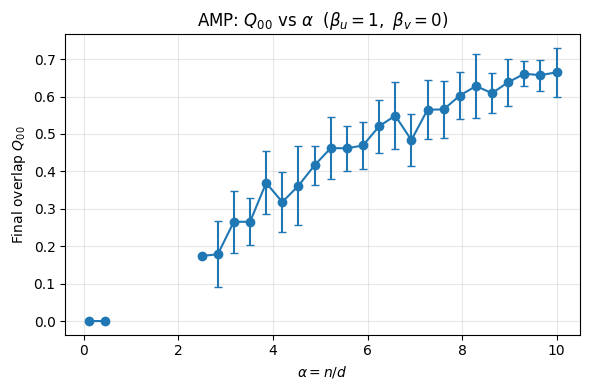

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- choose sweep settings ---
d = 500
alpha_list =  np.linspace(0.1, 10, 30)
runs_per_alpha = 10
plant = 0.7

# --- storage ---
alpha_vals = []
q00_mean = []
q00_std = []

for i, alpha in tqdm(enumerate(alpha_list)):
    res = run_many_amp(
        runs=runs_per_alpha,
        alpha=alpha,
        d=d,
        beta_u=1.0,
        beta_v=0.0,
        gamma=0.0,
        delta=0.0,
        plant=plant,
        damp=0.5,
        tol=1e-4,
        max_iter=500,
        eps=1e-6,
        seed0=123 + 1000*i  # change seeds across alpha values
    )

    # collect final Q[0,0] from converged runs
    q00s = []
    for r in res:
        if r["converged"] and len(r["overlap_hist"]) > 0:
            Q_final = r["overlap_hist"][-1]  # shape (K, K)
            q00s.append(Q_final[0, 0])

    if len(q00s) == 0:
        alpha_vals.append(alpha)
        q00_mean.append(np.nan)
        q00_std.append(np.nan)
    else:
        alpha_vals.append(alpha)
        q00_mean.append(float(np.mean(q00s)))
        q00_std.append(float(np.std(q00s)))

# --- plot ---
plt.figure(figsize=(6,4))
plt.errorbar(alpha_vals, q00_mean, yerr=q00_std, fmt='o-', capsize=3)
plt.xlabel(r'$\alpha = n/d$')
plt.ylabel(r'Final overlap $Q_{00}$')
plt.title(r'AMP: $Q_{00}$ vs $\alpha$  ($\beta_u=1,\ \beta_v=0$)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
